## redBus Data Decode Hackathon 2025  and AV - Hiring Hackathon

## **Goal:** Predict final seat demand for intercity bus journeys at a route level, 15 days before the actual journey date.

**Key Features Provided:**
- Seats booked (historical)
- Date of journey (doj)
- Date of issue (doi)
- Search data (user searches per route per date)

**Key Influencing Factors:**
- National and regional holidays
- Wedding/festival seasons
- School vacations, exam schedules
- Day-of-week effects

**Objective:**
Build a predictive model that accurately estimates seat demand based on these factors and past behavior. The model should simulate what demand will be on a future date using data from 15 days prior.

**Evaluation Metric:** Root Mean Squared Error (RMSE)

**External Data Allowed:** Yes — national/regional holidays, festivals, cultural calendars (no other booking or seat data)

**Final Output:** A CSV file with predictions for seat counts, format: `id, final_seatcount`
"""

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import holidays
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")


In [2]:
#  Load data
train = pd.read_csv('train.csv', parse_dates=['doj'])
test = pd.read_csv('test_8gqdJqH.csv', parse_dates=['doj'])
transactions = pd.read_csv('transactions.csv', parse_dates=['doj', 'doi'])

### Calendar, Holiday & Cultural Features (Curated)

In [3]:
# Calendar, Holiday & Cultural Features (Curated)

def add_calendar_features(df):
    df['dayofweek'] = df['doj'].dt.dayofweek
    df['dayofmonth'] = df['doj'].dt.day
    df['month'] = df['doj'].dt.month
    return df

def add_national_holidays(df):
    years = df['doj'].dt.year.unique().tolist()
    ind_holidays = holidays.India(years=years)
    holiday_map = {pd.Timestamp(d): name for d, name in ind_holidays.items()}
    
    df['is_national_holiday'] = df['doj'].isin(holiday_map).astype(int)
    df['prev_day'] = df['doj'] - pd.Timedelta(days=1)
    df['next_day'] = df['doj'] + pd.Timedelta(days=1)
    df['long_weekend'] = (
        df['prev_day'].isin(holiday_map) | df['next_day'].isin(holiday_map)
    ).astype(int)

    holiday_dates = pd.to_datetime(pd.Series(list(holiday_map.keys())))
    df['nearby_holiday_count'] = df['doj'].apply(
        lambda x: ((holiday_dates >= x - pd.Timedelta(days=3)) & (holiday_dates <= x + pd.Timedelta(days=3))).sum()
    )
    df['holiday_name'] = df['doj'].map(holiday_map).fillna('None')
    return df

def add_wedding_festival_cues(df):
    df['is_wedding_season'] = df['doj'].dt.month.isin([1, 2, 11, 12]).astype(int)
    df['is_festival_season'] = df['doj'].dt.month.isin([10, 11]).astype(int)
    df['cultural_travel_score'] = df['is_wedding_season'] + df['is_festival_season']
    return df


In [4]:
# Apply these to all date-aware tables:

for df in [train, test, transactions]:
    df = add_calendar_features(df)

train = add_national_holidays(train)
test = add_national_holidays(test)

train = add_wedding_festival_cues(train)
test = add_wedding_festival_cues(test)

le_holiday = LabelEncoder()
train['holiday_name_encoded'] = le_holiday.fit_transform(train['holiday_name'])
test['holiday_name_encoded'] = le_holiday.transform(test['holiday_name'])


### DBD=15 Transaction Merge

In [5]:
# Slice DBD=15 data
dbd_15 = transactions[transactions['dbd'] == 15].copy()
dbd_15['seat_to_search_ratio'] = dbd_15['cumsum_seatcount'] / (dbd_15['cumsum_searchcount'] + 1)

# Columns to bring into train/test
merge_cols = ['doj', 'srcid', 'destid']
features_to_merge = [
    'cumsum_seatcount', 'cumsum_searchcount', 'seat_to_search_ratio',
    'srcid_region', 'destid_region', 'srcid_tier', 'destid_tier'
]

# Merge onto main set
train = train.merge(dbd_15[merge_cols + features_to_merge], on=merge_cols, how='left')
test = test.merge(dbd_15[merge_cols + features_to_merge], on=merge_cols, how='left')

# Add route frequency as proxy for historical importance
route_freq = dbd_15.groupby(['srcid', 'destid']).size().reset_index(name='route_freq')
train = train.merge(route_freq, on=['srcid', 'destid'], how='left')
test = test.merge(route_freq, on=['srcid', 'destid'], how='left')


### DBD 16–30 Trend Slopes & Rolling Stats

In [6]:
# Get trends from DBDs 16 to 30 (past beyond DBD=15)
trend = transactions[(transactions['dbd'] >= 16) & (transactions['dbd'] <= 30)].copy()
trend = trend.sort_values(by=['srcid', 'destid', 'doj', 'dbd'])

# Δ seat/search over time (day-to-day change)
trend['delta_seats'] = trend.groupby(['srcid', 'destid', 'doj'])['cumsum_seatcount'].diff().fillna(0)
trend['delta_search'] = trend.groupby(['srcid', 'destid', 'doj'])['cumsum_searchcount'].diff().fillna(0)

# Rolling mean and std of booking and search volume changes
rolling_stats = trend.groupby(['srcid', 'destid', 'doj']).agg({
    'delta_seats': ['mean', 'std'],
    'delta_search': ['mean', 'std']
}).reset_index()
rolling_stats.columns = ['srcid', 'destid', 'doj',
                         'seat_trend_mean', 'seat_trend_std',
                         'search_trend_mean', 'search_trend_std']


In [7]:
# Add Linear Booking/Search Trend Slopes

def compute_trend_slopes(group):
    if len(group) < 3:
        return pd.Series({'seat_slope': 0.0, 'search_slope': 0.0})
    X = group['dbd'].values.reshape(-1, 1)
    seat_model = LinearRegression().fit(X, group['cumsum_seatcount'].values)
    search_model = LinearRegression().fit(X, group['cumsum_searchcount'].values)
    return pd.Series({
        'seat_slope': seat_model.coef_[0],
        'search_slope': search_model.coef_[0]
    })

slopes = trend.groupby(['srcid', 'destid', 'doj']).apply(compute_trend_slopes).reset_index()
trend_features = rolling_stats.merge(slopes, on=['srcid', 'destid', 'doj'], how='left')

# Merge into train/test
train = train.merge(trend_features, on=['srcid', 'destid', 'doj'], how='left')
test = test.merge(trend_features, on=['srcid', 'destid', 'doj'], how='left')


### Label Encoding + Interaction Features

In [8]:
# Encode Categorical Route Traits

cat_cols = ['srcid_region', 'destid_region', 'srcid_tier', 'destid_tier']

for col in cat_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))

# Create Composite Route Signatures
train['route'] = train['srcid'].astype(str) + '_' + train['destid'].astype(str)
test['route'] = test['srcid'].astype(str) + '_' + test['destid'].astype(str)

route_le = LabelEncoder()
train['route'] = route_le.fit_transform(train['route'])
test['route'] = route_le.transform(test['route'])


In [9]:
# Engineer Interaction Features

train['search_density'] = train['cumsum_searchcount'] / (train['route_freq'] + 1)
test['search_density'] = test['cumsum_searchcount'] / (test['route_freq'] + 1)

train['search_trend_weekly'] = train['search_trend_mean'] * train['dayofweek']
test['search_trend_weekly'] = test['search_trend_mean'] * test['dayofweek']

train['demand_skew_ratio'] = train['seat_to_search_ratio'] * train['search_trend_mean']
test['demand_skew_ratio'] = test['seat_to_search_ratio'] * test['search_trend_mean']


### Feature Selection & LightGBM Training

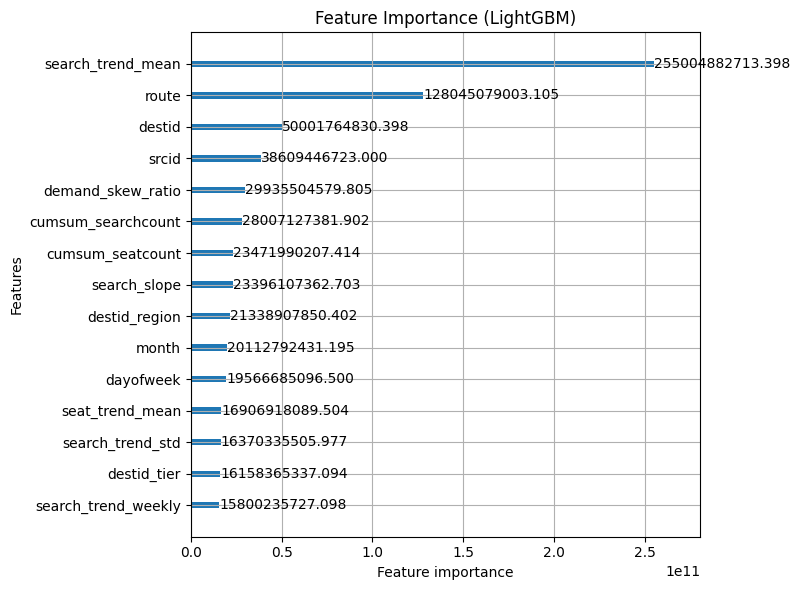

In [19]:
# Feature Importance
import matplotlib.pyplot as plt

lgb.plot_importance(model, max_num_features=15, importance_type='gain', figsize=(8, 6))
plt.title("Feature Importance (LightGBM)")
plt.tight_layout()
plt.show()

In [10]:
# Define Target and Final Feature Set

target = 'final_seatcount'

features = [
    # Core route + time
    'srcid', 'destid', 'route', 'dayofweek', 'dayofmonth', 'month',
    
    # DBD=15 transactional
    'cumsum_seatcount', 'cumsum_searchcount', 'seat_to_search_ratio',
    'route_freq', 'search_density',
    
    # DBD 16–30 trends
    'seat_trend_mean', 'seat_trend_std',
    'search_trend_mean', 'search_trend_std',
    'seat_slope', 'search_slope',
    
    # Interactions
    'search_trend_weekly', 'demand_skew_ratio',
    
    # Cultural modifiers
    'is_wedding_season', 'is_festival_season', 'cultural_travel_score',
    'is_national_holiday', 'long_weekend', 'nearby_holiday_count', 'holiday_name_encoded',
    
    # Route categories
] + cat_cols  # These were encoded earlier


In [11]:
# Create Train/Validation Split Based on Time (to reduce leakage)

cutoff = train['doj'].quantile(0.8)
train_split = train[train['doj'] <= cutoff]
val_split = train[train['doj'] > cutoff]

X_train, y_train = train_split[features], train_split[target]
X_val, y_val = val_split[features], val_split[target]


In [12]:
# Train LightGBM with Early Stopping

train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.045,
    'num_leaves': 96,
    'feature_fraction': 0.85,
    'bagging_fraction': 0.8,
    'lambda_l1': 1.5,
    'lambda_l2': 1.5,
    'verbosity': -1,
    'seed': 42
}

model = lgb.train(
    params,
    train_data,
    valid_sets=[val_data],
    num_boost_round=3000,
    early_stopping_rounds=100,
    verbose_eval=100
)

val_preds = model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
print(f"\n Final Validation RMSE: {val_rmse:.4f}")


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 625.233
[200]	valid_0's rmse: 604.919
[300]	valid_0's rmse: 600.099
[400]	valid_0's rmse: 598.216
[500]	valid_0's rmse: 597.932
[600]	valid_0's rmse: 597.564
[700]	valid_0's rmse: 597.771
Early stopping, best iteration is:
[618]	valid_0's rmse: 597.415

 Final Validation RMSE: 597.4147


### Ridge Bias Correction + Submission Output

In [13]:
# Add LightGBM predictions to validation split
val_split = val_split.copy()
val_split['preds'] = val_preds

# Ridge bias correction
ridge = Ridge()
ridge.fit(val_split[['preds', 'dayofweek']], y_val)


,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [14]:
# Predict on Test Set Using Trained LightGBM Model

X_test = test[features]
raw_preds = model.predict(X_test)

# Build ridge input for test
calib_df = pd.DataFrame({
    'preds': raw_preds,
    'dayofweek': test['dayofweek']
})

# Calibrate final predictions
calibrated_preds = ridge.predict(calib_df)


In [15]:
# Predict on Test Set Using Trained LightGBM Model
X_test = test[features]
raw_preds = model.predict(X_test)

# Build ridge input for test
calib_df = pd.DataFrame({
    'preds': raw_preds,
    'dayofweek': test['dayofweek']
})

# Calibrate final predictions
calibrated_preds = ridge.predict(calib_df)


In [16]:
# Optional Boost on High-Frequency Routes

boost_mask = test['route_freq'] >= test['route_freq'].quantile(0.98)
calibrated_preds[boost_mask] += 50  # Tune this if needed


In [17]:
# Generate Submission CSV

submission = test[['route_key']].copy()
submission['final_seatcount'] = np.clip(calibrated_preds, 0, None).round().astype(int)
submission.to_csv('submission_final_blend.csv', index=False)
print("\n Submission saved: submission_final_blend.csv")
#print(" Total predicted seat count:", submission['final_seatcount'].sum())


 Submission saved: submission_final_blend.csv


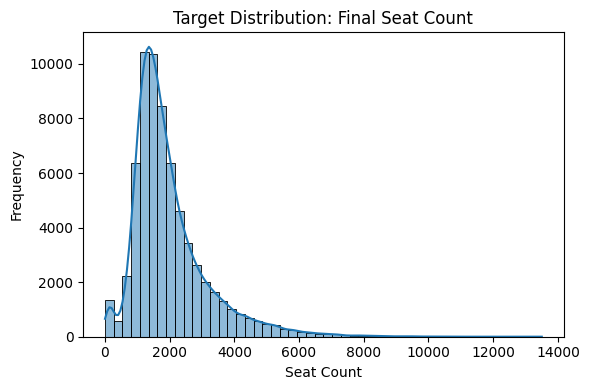

In [21]:
# 6. Target Distribution Plot
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.histplot(train['final_seatcount'], bins=50, kde=True)
plt.title("Target Distribution: Final Seat Count")
plt.xlabel("Seat Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()